# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [42]:
# игнорирование всех предупреждений
import warnings
warnings.filterwarnings("ignore")

In [41]:
# импорт основных библиотек для работы с данными
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [53]:
# импорт библиотек для Маш.Об
# решающее дерево:
from sklearn.tree import DecisionTreeClassifier
# случайное дерево:
from sklearn.ensemble import RandomForestClassifier
# логистическая регрессия:
from sklearn.linear_model import LogisticRegression
# для разбивки на выборки
from sklearn.model_selection import train_test_split
# для поиска оптимальных гиперпараметров
from sklearn.model_selection import GridSearchCV

Прежде всего сделаем выгрузку данных и познакомимся с ними:

In [45]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

Посмотрим, что у нас хранится в датафрейме:

In [46]:
df.sample(5)

,calls,minutes,messages,mb_used,is_ultra
1988,69.0,522.16,9.0,15834.77,0
921,93.0,722.64,0.0,14198.92,0
2234,70.0,489.70,13.0,10671.53,0
1604,95.0,614.91,0.0,13616.61,0
2368,82.0,539.18,46.0,16021.77,0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Посмотрим на количество объектов и признаков:

In [48]:
df.shape

(3214, 5)

Из дополнительной документации определили следующие значения признаков:
* **calls** - количество звонков;
* **minutes** - суммарная длительность звонков в минутах;
* **messages** - количество sms-сообщений;
* **mb_used** - израсходованный интернет-трафик в МБ;
* **is_ultra** - каким тарифом пользовался в течение месяца:
    * `1` - тариф "Ультра";
    * `0` - тариф "Смарт".
    
Из дополнительной информации известно, что данные уже предобработаны, поэтому предварительную обработку данных мы проводить не будем.

### Вывод
После выгрузки датасета, познакомились с содержащейся в ней информацией, определили количество признаков и объектов, с помощью которых будем решать задачу классификации.

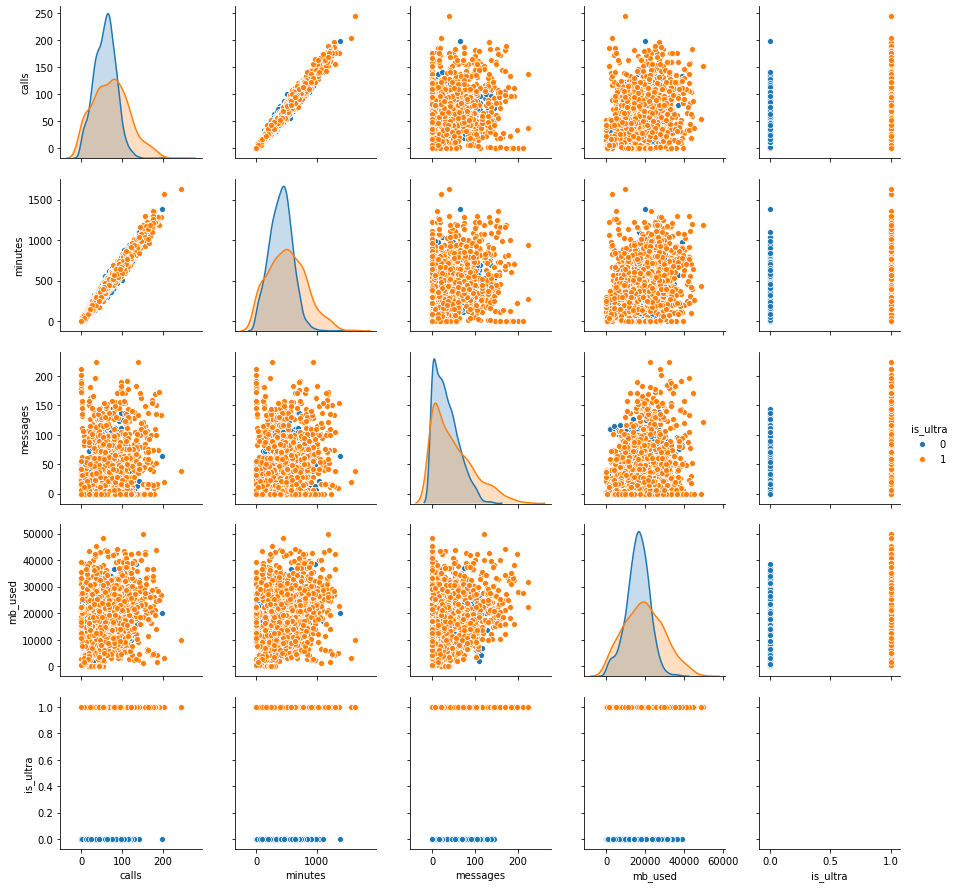

In [52]:
sns.pairplot(df, hue = 'is_ultra')

<div class="alert alert-block alert-info">
<b>Комментарий студента</b> Построил матрицу диаграмм рассеяния. Вижу, что у нас есть лишние для обучения данных - это количество минут или количество звонков, так как они имеют сильную положительную зависимость
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Верно, это называется мультиколленаирностью!

## Разбейте данные на выборки

Прежде чем начать реализацию модели классификации, разобьем наши данные на следующие группы:
* **Обучающая выборка** - с помощью которой обучим нашу модель;
* **Валидационная выборка** - с помощью которой будем проверять корректность алгоритма во время обучения;
* **Тестовая выборка** - сторонние данные, по которым определим, как модель наша обучена.

Так как тестовая выборка изначально отсутствует, разобьем наш датасет в следующих пропорциях:
* **Обучающая выборка** - 60% исходных данных;
* **Валидационная выборка** - 20% исходных данных;
* **Тестовая выборка** - 20% исходных данных.

In [54]:
# split_df - используется для дальнейшего разбиения 
train_df, split_df = (
    train_test_split(df, test_size = 0.4, random_state = 54321)
)

Посмотрим, как мы разбили наши данные:

In [55]:
train_df.shape

(1928, 5)

In [56]:
split_df.shape

(1286, 5)

Теперь получим **тестовую** и **валидационную** выборки

In [57]:
validate_df, test_df = (
    train_test_split(split_df, test_size = 0.5, random_state = 54321)
)

Посмотрим, что получилось в итоге:

Валидационная выборка:

In [58]:
validate_df.shape

(643, 5)

In [59]:
test_df.shape

(643, 5)

### Вывод
Разбили наш датасет на выборки в следующих пропорциях:
* **Обучающая выборка** - 60% исходных данных;
* **Валидационная выборка** - 20% исходных данных;
* **Тестовая выборка** - 20% исходных данных

Теперь перейдем к реализации модели.

<div class="alert alert-block alert-success">
    
<b>Успех:</b> С разбиением все хорошо, молодец, что не забываешь проверять размеры полученных выборки,  это иной раз может предостеречь тебя от глупых ошибок.
  </div>  


## Исследуйте модели

Прежде чем начнем моделирование, необходимо определить, что мы планируем прогнозировать?

Так как в задании указано, создать модель для задачи классификации подбора подходящего тарифа, то создадим модель бинарной классификации. Для этого определим признаки (вопросы) и целевой признак (ответы) для нашего алгоритма.

**Признаки**:

   * **calls** - количество звонков;
   * **minutes** - суммарная длительность звонков в минутах;
   * **messages** - количество sms-сообщений;
   * **mb_used** - израсходованный интернет-трафик в МБ;

**Целевой признак**:
    
   * **is_ultra** - каким тарифом пользовался в течение месяца:
        * `1` - тариф "Ультра";
        * `0` - тариф "Смарт". 

In [60]:
features = train_df.drop('is_ultra', 1)

In [61]:
target = train_df.is_ultra

In [62]:
features_valid = validate_df.drop('is_ultra', 1)
target_valid = validate_df.is_ultra

Для начала обучим модель разными способами (со стандартными гиперпараметрами):
* Модель решающего дерева;
* Модель случайного леса;
* Модель логистической регресии.

**Модель решающего дерева**:

In [17]:
model_tree = DecisionTreeClassifier(random_state = 54321)
model_tree.fit(features, target)
result = model_tree.score(features_valid, target_valid)
print(f'Точность решающего дерева: {result}')

Точность решающего дерева: 0.687402799377916


**Модель случайного леса**:

In [18]:
# поставил n-estimators, чтобы избавиться от warning'a
model_forest = RandomForestClassifier(random_state = 54321)
model_forest.fit(features, target)
result = model_forest.score(features_valid, target_valid)
print(f'Точность случайного леса: {result}')

Точность случайного леса: 0.7698289269051322


**Модель логистической регрессии**:

In [19]:
model_log = LogisticRegression(random_state = 54321)
model_log.fit(features, target)
result = model_log.score(features_valid, target_valid)
print(f'Точность логистической регрессии: {result}')

Точность логистической регрессии: 0.6780715396578538


Здесь мы видим следующие результаты обучения разных моделей со стандартными гиперпараметрами:

* По доле правильных ответов лучше всего модель случайного леса. Однако в качестве стандартных параметров используется 10 деревьев, что увеличивает время обучения данной модели.
* Модель логистической регрессии и решающего дерева не справились с требуемой долей правильных ответов. 

Поэтому проведем исследование зависимости точности обучения модели от гиперпараметров

## Исследование моделей в зависимости от гиперпарметров

**Модель решающего дерева**

Посмотрим, какие гиперпараметры можно менять вручную у модели решающего дерева:

In [20]:
# закомментировано для удобства
#DecisionTreeClassifier?

Видим, что можно изменить большое количество гиперпараметров. В рамках работы ограничимся тремя параметрами:

   * `max_depth` - глубина дерева;
   * `min_samples_split` - минимальное количество объектов в узле дерева, достаточное для дальнейшего разделения;
   * `min_samples_leaf` — минимальное число объектов в листьях дерева — нижних узлах с ответами.

Попробуем изменить эти гиперпараметры и посмотреть на реузльтаты обучения.

In [21]:
best_model_tree = None
best_result = 0
best_samples_split = 0
best_samples_leaf = 0
best_depth = 0
for samp_split in range(2,4):
    for samp_leaf in range(1,3):
        for depth in range(3,11):
            model = (
                DecisionTreeClassifier(random_state = 54321, 
                                       max_depth = depth,
                                      min_samples_split = samp_split,
                                      min_samples_leaf = samp_leaf)
            )
            
            model.fit(features, target)
            result = model.score(features_valid, target_valid)
            
            print(f'Точность: {result}')
            print(f'Глубина дерева: {depth}')
            print(f'Количество объектов в узле дерева: {samp_split}')
            print(f'Количество объектов в листе дерева: {samp_leaf} \n')
            
            if result > best_result:
                best_result = result
                best_model_tree = model
                best_samples_split = samp_split
                best_samples_leaf = samp_leaf
                best_depth = depth
    
print(f'Лучшая точность: {best_result}')
print(f'Глубина дерева: {best_depth}')
print(f'Количество объектов в узле дерева: {best_samples_split}')
print(f'Количество объектов в листе дерева: {best_samples_leaf}')

Точность: 0.7651632970451011
Глубина дерева: 3
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.744945567651633
Глубина дерева: 4
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.7651632970451011
Глубина дерева: 5
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.7542768273716952
Глубина дерева: 6
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.7433903576982893
Глубина дерева: 7
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.7511664074650077
Глубина дерева: 8
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.7682737169517885
Глубина дерева: 9
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность: 0.7822706065318819
Глубина дерева: 10
Количество объектов в узле дерева: 2
Количество объектов в листе дерева: 1 

Точность

В процессе моделирования определили, что на точность влияет такой гиперпараметр, как глубина дерева. Определим, как глубина дерева влияет на точность модели (остальные гиперпараметры стандартные).

In [22]:
accuracy_list = []
depth_lst = []
best_model_tree = None
best_result = 0
best_depth = 0
for depth in range(1,15):
    model = (
         DecisionTreeClassifier(random_state = 54321, 
                                       max_depth = depth)
            )
    model.fit(features, target)
    result = model.score(features_valid, target_valid)
    accuracy_list.append(result)
    depth_lst.append(depth)
    print(f'Глубина дерева = {depth}, доля правильных ответов = {result}')
    if result > best_result:
        best_model_tree = model
        best_result = result
        best_depth = depth
print(f'\nЛучшая точность: {best_result}')
print(f'Глубина дерева: {best_depth}')

Глубина дерева = 1, доля правильных ответов = 0.7216174183514774
Глубина дерева = 2, доля правильных ответов = 0.7418351477449455
Глубина дерева = 3, доля правильных ответов = 0.7651632970451011
Глубина дерева = 4, доля правильных ответов = 0.744945567651633
Глубина дерева = 5, доля правильных ответов = 0.7651632970451011
Глубина дерева = 6, доля правильных ответов = 0.7542768273716952
Глубина дерева = 7, доля правильных ответов = 0.7433903576982893
Глубина дерева = 8, доля правильных ответов = 0.7511664074650077
Глубина дерева = 9, доля правильных ответов = 0.7682737169517885
Глубина дерева = 10, доля правильных ответов = 0.7822706065318819
Глубина дерева = 11, доля правильных ответов = 0.7729393468118196
Глубина дерева = 12, доля правильных ответов = 0.7480559875583204
Глубина дерева = 13, доля правильных ответов = 0.7387247278382582
Глубина дерева = 14, доля правильных ответов = 0.7356143079315708

Лучшая точность: 0.7822706065318819
Глубина дерева: 10


In [23]:
df_to_plot = pd.DataFrame({'depth' : depth_lst, 'accuracy' : accuracy_list})

(array([0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79]),
 <a list of 9 Text yticklabel objects>)

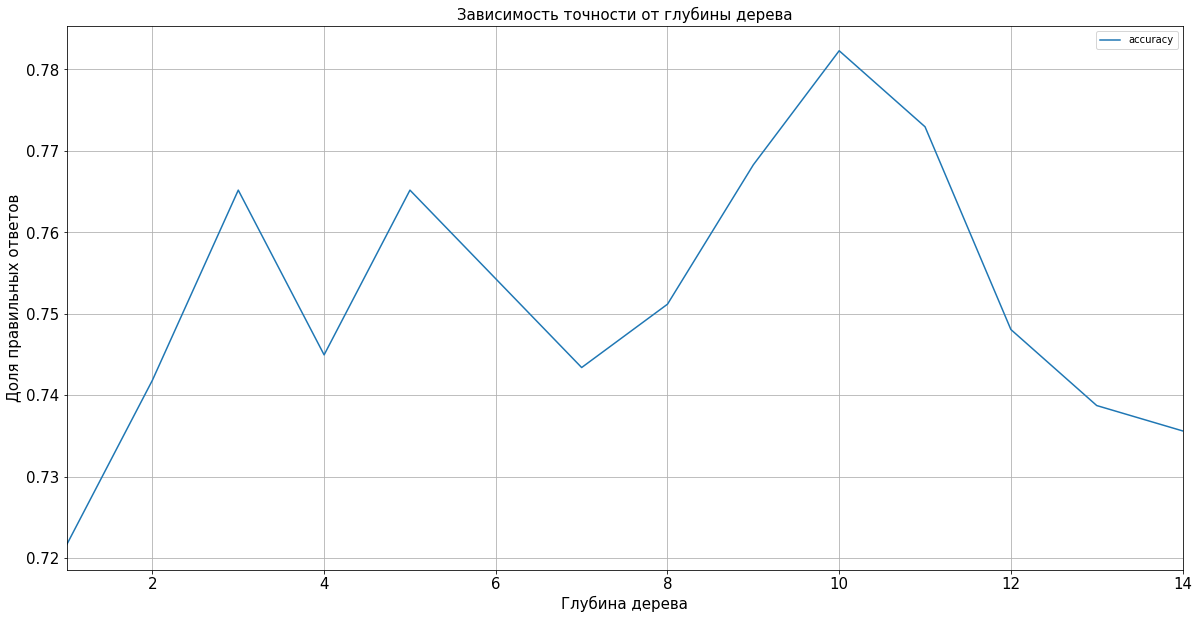

In [24]:
df_to_plot.plot(kind = 'line', x = 'depth', y = 'accuracy', figsize = (20,10), grid = True)
plt.title('Зависимость точности от глубины дерева', fontsize = 15)
plt.ylabel('Доля правильных ответов', fontsize = 15)
plt.xlabel('Глубина дерева', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

Видим, что если глубина дерева маленькая, то доля правильных моделей модели низкая, однако после глубины дерева, равной 10 наблюдается снижение доли правильных ответов. Это связано с тем, что модель недообучена (в случае малой глубины) или переобучена (глубина больше 10).

Теперь проведем исследование гиперпараметров модели случайного леса

**Модель случайного леса**

Посмотрим, какие гиперпараметры можно менять у модели случайного леса:

In [25]:
#RandomForestClassifier?

Видим, можем менять следующие гиперпараметры:
* `n-estimators` - количество деревьев;
* `max_depth` - глубина дерева;
* `criterion` - критерий ("Джини" или энтропия).

Посмотрим, как меняется доля правильных ответов в зависимости от гиперпараметров.

In [26]:
best_model_forest = None
best_result = 0
best_depth = 0
best_est = 0
accuracy_lst = []
est_lst = []
depth_lst = []
for est in range(1, 15):
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state = 54321, max_depth = depth, n_estimators = est)
        model.fit(features, target)
        result = model.score(features_valid, target_valid)
        
        accuracy_lst.append(result)
        est_lst.append(est)
        depth_lst.append(depth)
        
        if result > best_result:
            best_model_forest = model
            best_result = result
            best_depth = depth
            best_est = est
            
print(f'Наибольшая доля правильных ответов: {best_result}')
print(f'Глубина дерева: {best_depth}')
print(f'Количество деревьев: {best_est}')

Наибольшая доля правильных ответов: 0.80248833592535
Глубина дерева: 10
Количество деревьев: 8


In [27]:
df_to_plot = pd.DataFrame({'est': est_lst, 'depth': depth_lst, 'accuracy' : accuracy_lst})

In [28]:
df_to_plot.head()

,est,depth,accuracy
0,1,1,0.721617
1,1,2,0.751166
2,1,3,0.738725
3,1,4,0.741835
4,1,5,0.760498


Построим график зависимости доли правильных ответов от количества деревьев, в качестве глубины дерева возьмем размер, равный 10.

In [29]:
df_to_plot = df_to_plot.query('depth == 10')

(array([0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81]),
 <a list of 9 Text yticklabel objects>)

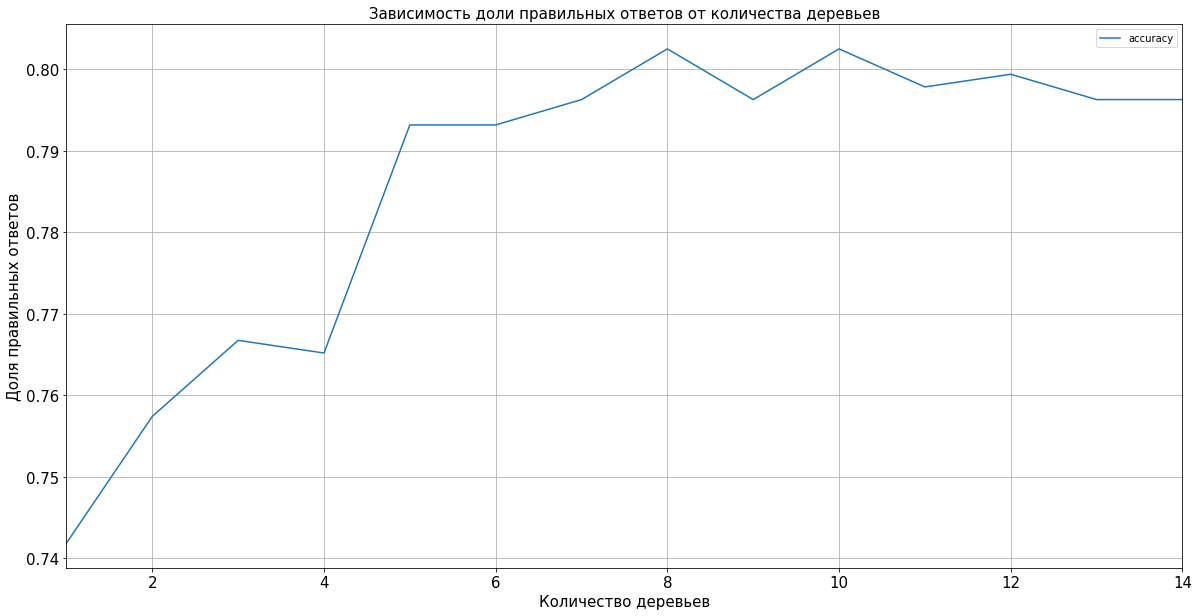

In [30]:
df_to_plot.plot(kind = 'line', x = 'est', y = 'accuracy', figsize = (20,10), grid = True)
plt.title('Зависимость доли правильных ответов от количества деревьев', fontsize = 15)
plt.ylabel('Доля правильных ответов', fontsize = 15)
plt.xlabel('Количество деревьев', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

Здесь мы видим следующее: чем больше деревьев, тем больше доля правильных ответов. При этом необходимо учитвать глубину каждого дерева, так как если глубина маленькая, то модель будет недообучена, иначе - переобучена.

Теперь рассмотрим модель логистической регресии

**Логистическая регрессия**

Прежде всего посмотрим на количество гиперпараметров в данной модели:

In [31]:
# закомментировано для удобства
#LogisticRegression?

Видим, что гиперпараметров у этой модели не так много, по сравнению с другими моделями в сравнении. Посмотрим на результаты обучения модели.

In [32]:
solver_lst = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
for i in range(len(solver_lst)):
    model = LogisticRegression(random_state = 54321, solver = solver_lst[i])
    model.fit(features, target)
    result = model.score(features_valid, target_valid)
    print(f'Доля правильных ответов: {result}, Решатель: {solver_lst[i]}')

Доля правильных ответов: 0.6780715396578538, Решатель: liblinear
Доля правильных ответов: 0.7076205287713841, Решатель: newton-cg
Доля правильных ответов: 0.6749611197511665, Решатель: lbfgs
Доля правильных ответов: 0.6516329704510109, Решатель: sag
Доля правильных ответов: 0.6516329704510109, Решатель: saga


Здесь мы видим следующее: в зависимости от решателя получаем разную долю правильных ответов. Лучший показетель по количеству правильных ответов у решателя `newton-cg` с долей, равной 70%.

### Вывод

В результате иссследования установили, что в зависимости от гиперпараметров, которые подбираются перед обучением модели, получаем разную долю правильных ответов. 
* Лучше всего показала себя модель случайного леса. Доля правильных ответов составила 80%. Однако это самая медленная модель среди остальных в сравнении; Чем больше деревьев используются в модели, тем дольше обучается модель
* "Золотой серединой" показала себя модель решающего дерева. Модель быстро обучилась, а доля правильных ответов составляет 78%, что на 2% меньше по сравнению со случайным лесом. При этом обратили внимание, что в зависимости от глубины дерева, мы можем получить эффект недообучения (глубина дерева маленькая) или переобучения (глубина дерева слишком большая).
* Хуже всего показала себя модель логистической регрессии, при применении модели на валидационной выборке получили 67-70% правильных ответов. 

В данном случае воспользуемся моделью случайного леса для тестовой выборки.

## Проверьте модель на тестовой выборке

In [33]:
test_f = test_df.drop('is_ultra', 1)
test_t = test_df.is_ultra

In [34]:
# best_model_forest - лучшая модель случайного леса, которую получили в результате проверки гиперпараметров
test_result = best_model_forest.score(test_f, test_t)
print(f'Доля правильных ответов: {test_result}')

Доля правильных ответов: 0.8227060653188181


Видим, что на тестовой выборке доля правильных ответов составила 82%. Это хороший показатель, так как на валидационной выборке доля правильных ответов составила 80%. 

## (бонус) Проверьте модели на адекватность

Теперь проверим нашу модель на адекватность. Здесь возможно несколько вариантов проверки:
1. Проверка нашей модели со случайной. Здесь подразумевается обучение нашей модели по целевому признаку, который генерируется случайно и далее проверяется на валидационной выборке; 
2. Известно количество классов и элементов в каждом классе в целевом признаке. Можно сравнить вероятность получения наиболее вероятного значения целевого признака исходной выборки с результатом отработки модели.

Начнем с первого метода.

In [35]:
df['is_ultra_rand'] = np.random.choice([0,1], len(df), 0.5)

In [36]:
df.is_ultra_rand.value_counts()

0    1633
1    1581
Name: is_ultra_rand, dtype: int64

Далее сформируем обучающую, валидационную выборки.

In [37]:
features = df.drop(['is_ultra', 'is_ultra_rand'], 1)
target = df.is_ultra_rand

In [38]:
train_features, val_features, train_target, val_target = (
    train_test_split(features,target, test_size = 0.2, random_state = 54321)
)

Теперь обучим по сформированным параметрам нашу модель случайного леса.

In [39]:
best_model_forest.fit(train_features, train_target)
result_v = best_model_forest.score(val_features, val_target)
result_t = best_model_forest.score(test_f, test_t)
print(f'Доля правильных ответов в валидационной выборке: {result_v}')
print(f'Доля правильных ответов в тестовой выборке: {result_t}')

Доля правильных ответов в валидационной выборке: 0.5427682737169518
Доля правильных ответов в тестовой выборке: 0.48522550544323484


Видим, что доля правильных ответов на тестовой выборке составляет 50% при случайной модели, что меньше, чем мы получили в результате проверки модели, обученной по готовым данным, а не сформированным случайно. 

Модель проверку на адекватность прошла.

Теперь рассмотрим простейший случай. Можно сравнить вероятность получения наиболее вероятного значения целевого признака исходной выборки с результатом отработки модели. Если модель предсказывает лучше, чем простая вероятность получения наиболее частого значения целевого признака, то модель адекватна.

In [40]:
df.is_ultra.value_counts()[0] / df.shape[0]

0.693528313627878

Видим, что вероятность получения наиболее частого значения в выборке меньше, чем доля правильных ответов в нашей модели.

Модель проверку на адекватность прошла.

## Вывод

В процессе формирования прогноза предпочитаемого тарифа определили задачу типа бинарной классификации.
* Сформировали обучающую, валидационную и тестовую выборки в следующих пропорциях:
    * обучающая - 60%
    * валидационная - 20%
    * тестовая - 20%
* Определили признаки и целевой признак для задачи бинарной классификации
* Провели исследование гиперпараметров для моделей машинного обучения:
    * Решающее дерево;
    * Случайный лес;
    * Логистическая регрессия.
* Получили следующие результаты:
    * Лучше всего показала себя модель случайного леса. Доля правильных ответов составила 80%. Однако это самая медленная модель среди остальных в сравнении; Чем больше деревьев используются в модели, тем дольше обучается модель
    * "Золотой серединой" показала себя модель решающего дерева. Модель быстро обучилась, а доля правильных ответов составляет 78%, что на 2% меньше по сравнению со случайным лесом. При этом обратили внимание, что в зависимости от глубины дерева, мы можем получить эффект недообучения (глубина дерева маленькая) или переобучения (глубина дерева слишком большая).
    * Хуже всего показала себя модель логистической регрессии, при применении модели на валидационной выборке получили 67-70% правильных ответов.

* Проверили лучшую по доле правильных ответов на тестовой выборке, полученная доля верных ответов составила 82%
* Проверили модель на адекватность. Модель прошла проверки на адекватность.